# NoSQL (HBase) (sesión 5)

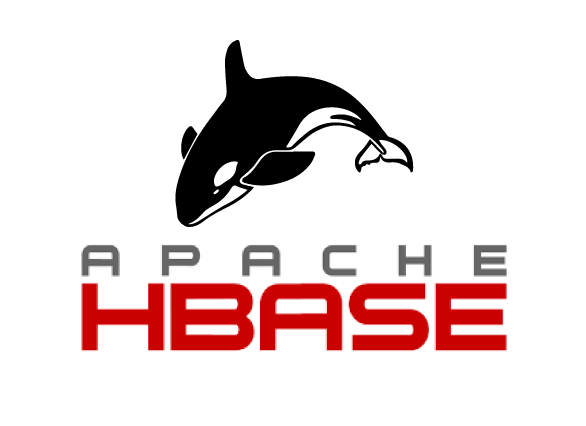



Esta hoja muestra cómo acceder a bases de datos HBase y también a conectar la salida con Jupyter.

Se puede utilizar el *shell* propio de HBase en la máquina virtual.

Con HBase vamos a simular un modo _semi-clúster_ con una sola máquina.


In [ ]:
%%bash
sudo apt-get update -qq
sudo apt-get install -y default-jdk

In [ ]:
import os
from pathlib import Path
p = Path('/usr/lib/jvm')
(_, dirs, _) = next(os.walk(str(p)))
os.environ['JAVA_HOME'] = str(p / dirs[0])

In [ ]:
%pip install bs4 lxml

In [ ]:
# Determinar qué versión 2.x de HBase es la más reciente.
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import re
from re import Pattern, Match

version_re: Pattern = re.compile(r'^(2\.[0-9]+(\.[0-9]+)?)')
req = Request("https://downloads.apache.org/hbase/")
html_page = urlopen(req)

soup = BeautifulSoup(html_page)

bigger2x = '2.0.0'  # Base version 2.x.x
for link in soup.findAll('a'):
  mresult: Match | None = version_re.match(link.get_text())
  if mresult and mresult.group(0) > bigger2x:
    bigger2x = mresult.group(0)

In [ ]:
%env HBASE_VERSION=$bigger2x

In [ ]:
%%bash
wget -q https://downloads.apache.org/hbase/$HBASE_VERSION/hbase-$HBASE_VERSION-bin.tar.gz
tar -xzf hbase-$HBASE_VERSION-bin.tar.gz
rm -rf hbase-$HBASE_VERSION-bin.tar.gz

In [ ]:
%%bash
hbase-$HBASE_VERSION/bin/start-hbase.sh
hbase-$HBASE_VERSION/bin/hbase-daemon.sh restart thrift

In [ ]:
from pprint import pprint as pp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')

Usaremos la librería `happybase` para python. La cargamos a continuación y hacemos la conexión.

In [ ]:
%pip install git+https://github.com/python-happybase/happybase.git

La conexión con la BD dura pocos segundos abierta porque está pensada para que un programa se conecte, haga una consulta y se desconecte. Al estar en una sesión interactiva, construyo un objeto `Connection` que genera un pool de conexiones. Si se desconecta, prueba otra vez.

In [ ]:
from typing import Generator
import happybase
from happybase import ConnectionPool
from contextlib import contextmanager

HBASEHOST: str = 'localhost'

class Connection():

    def __init__(self, host: str):
        self.host: str = host
        self._genpool()

    def _genpool(self):
        self.pool = ConnectionPool(size=5, host=self.host)

    @contextmanager
    def connection(self) -> Generator[happybase.Connection, None, None]:
        for _ in range(5): # Probar 5 veces a regenerar el pool
            for _ in range(5): # Probar 5 veces a conectar
                with self.pool.connection() as connection:
                    try:
                        connection.tables()
                        yield connection
                        return
                    except Exception as _:
                        pass
            self._genpool()
        raise Exception("HBase Connection Error")

In [ ]:
pool = Connection(HBASEHOST)

Para la carga inicial, vamos a crear todas las tablas con una única familia de columnas, `rawdata`, donde meteremos toda la información _raw_ comprimida. Después podremos hacer reorganizaciones de los datos para hacer el acceso más eficiente. Es una de las muchas ventajas de no tener un esquema.

In [ ]:
# Create tables
tables = ['posts', 'votes', 'users', 'tags', 'comments']
for t in tables:
    try:
        with pool.connection() as connection:
            connection.create_table(
                t,
                {
                    'rawdata': dict(max_versions=1,compression='GZ')
                })
    except Exception as e:
        print("Database already exists: {0}. {1}".format(t, e))
        pass
with pool.connection() as connection:
    print(connection.tables())

Descarga de datos:

In [ ]:
%%bash
wget https://github.com/dsevilla/bd2-data/raw/main/es.stackoverflow/es.stackoverflow.csv.7z.001
wget https://github.com/dsevilla/bd2-data/raw/main/es.stackoverflow/es.stackoverflow.csv.7z.002

In [ ]:
%%bash
7zr x es.stackoverflow.csv.7z.001
rm -rf es.stackoverflow.csv.7z.001
rm -rf es.stackoverflow.csv.7z.002

In [ ]:
!head Users.csv

El código de importación es siempre el mismo, ya que se coge la primera fila del CSV que contiene el nombre de las columnas y se utiliza para generar nombres de columnas dentro de la familia de columnas dada como parámetro. La función `csv_to_hbase()` acepta un fichero CSV a abrir, un nombre de tabla y una familia de columnas donde agregar las columnas del fichero CSV. En nuestro caso siempre va a ser `rawdata`.

In [ ]:
import csv

def csv_to_hbase(file, tablename, cf):
    with pool.connection() as connection, open(file) as f:
        table = connection.table(tablename)

        # La llamada csv.reader() crea un iterador sobre un fichero CSV
        reader = csv.reader(f, dialect='excel')

        # Se leen las columnas. Sus nombres se usarán para crear las diferentes columnas en la familia
        columns = next(reader)
        columns = [cf + ':' + c for c in columns]

        with table.batch(batch_size=500) as b:
            for row in reader:
                # La primera columna se usará como Row Key
                b.put(row[0], dict(zip(columns[1:], row[1:])))

In [ ]:
for t in tables:
    print(f"Importando tabla {t}...")
    %time csv_to_hbase(t.capitalize() + '.csv', t, 'rawdata')

### Consultas sencillas desde Python

A continuación veremos algunas consultas sencillas desde python usando el API de `happybase`.

In [ ]:
with pool.connection() as connection:
    posts = connection.table('posts')

Obtener el Post con `Id` 5. La orden más sencilla e inmediata de HBase es obtener una fila, opcionalmente limitando las columnas a mostrar:

In [ ]:
posts.row(b'5',columns=[b'rawdata:Body'])

El siguiente código permite mostrar de forma amigable las tablas extraídas de la base de datos en forma de diccionario:

In [ ]:
# http://stackoverflow.com/a/30525061/62365
class DictTable(dict):
    # Overridden dict class which takes a dict in the form {'a': 2, 'b': 3},
    # and renders an HTML Table in IPython Notebook.
    def _repr_html_(self):
        htmltext = ["<table width=100%>"]
        for key, value in self.items():
            htmltext.append("<tr>")
            htmltext.append("<td>{0}</td>".format(key.decode('utf-8')))
            htmltext.append("<td>{0}</td>".format(value.decode('utf-8')))
            htmltext.append("</tr>")
        htmltext.append("</table>")
        return ''.join(htmltext)

In [ ]:
# Muestra cómo queda la fila del Id del Post 9997
DictTable(posts.row(b'5'))

In [ ]:
DictTable(posts.row(b'5',columns=[b'rawdata:AnswerCount',b'rawdata:AcceptedAnswerId']))

Y también se puede recorrer como un diccionario normal (el `decode` se utiliza para convertir los valores binarios de la base de datos a una codificación UTF-8):

In [ ]:
row = posts.row(b'5')
for key, value in row.items():
    print("Key = '%s', Value = '%s'" % (key, value.decode('utf-8')[:40]))

Finalmente, también se puede recorrer toda la tabla estableciendo filtros, que se estudiarán después. Se utiliza la función `scan`. Se puede iterar con los parámetros `key` y `data`. Por ejemplo, calcular el tamaño máximo de la longitud del texto de los posts:

**(OJO, es un ejemplo, no se debería hacer así)**

In [ ]:
max_len = 0
for key, data in posts.scan():
    cur_len = len(data[b'rawdata:Body'].decode('utf-8'))
    if cur_len > max_len:
        max_len = cur_len

print("Máxima longitud: %s caracteres." % (max_len))

### Construcción de estructuras anidadas

Al igual que pasaba con MongoDB, las bases de datos NoSQL como en este caso HBase permiten almacenar estructuras de datos complejas. En nuestro caso vamos a agregar los comentarios de cada pregunta o respuesta (post) en columnas del mismo. Para ello, creamos una nueva familia de columnas `comments`.

HBase es bueno para añadir columnas sencillas, por ejemplo que contengan un valor. Sin embargo, si queremos añadir objetos complejos, tenemos que jugar con la codificación de la familia de columnas y columna.

Usaremos el shell porque `happybase` no permite alterar tablas ya creadas. Para acceder al shell de HBase, tenemos que contactar al contenedor `hbase-regionserver`, de esta forma:

```bash
hbase-$HBASE_VERSION/bin/hbase shell
```

En el `shell` de HBase pondremos lo siguiente:

```
disable 'posts'
alter 'posts', {NAME => 'comments', VERSIONS => 1}
enable 'posts'
```

Cada comentario que añadimos contiene, al menos:

- un id único
- un texto
- un autor
- etc.

¿Cómo se consigue meterlo en una única familia de columnas?

Hay varias formas. La que usaremos aquí, añadiremos el **id** de cada comentario como parte del nombre de la columna. Por ejemplo, el comentario con Id 2000, generará las columnas:

- `Id_2000` (valor 2000)
- `UserId_2000`
- `PostId_2000`
- `Text_2000`

con sus correspondientes valores. Así, todos los datos relativos al comentario con Id original 2000, estarán almacenados en todas las columnas que terminen en "`_2000`". La base de datos permite implementar filtros que nos permiten buscar esto de forma muy sencilla. Los veremos después.

In [ ]:
!hbase-$HBASE_VERSION/bin/hbase shell

In [ ]:
with pool.connection() as connection:
    comments = connection.table('comments')
    posts = connection.table('posts')

    with posts.batch(batch_size=500) as bp:
        # Hacer un scan de la tabla
        for key, data in comments.scan():
            comment = {'comments:' +
                       d.decode('utf-8').split(':')[1] + "_" +
                       key.decode('utf-8') :
                       data[d].decode('utf-8') for d in data.keys()}
            bp.put(data[b'rawdata:PostId'], comment)

In [ ]:
DictTable(posts.row(b'7251'))

In [ ]:
%timeit q = posts.row(b'7251')

In [ ]:
from functools import reduce

def doit():
    q = posts.row(b'7251')
    (s,n) = reduce(lambda res, e:
                    (res[0]+len(e[1].decode('utf-8')), res[1]+1) if e[0].decode('utf-8').startswith('comments:Text') else res
                   , q.items(), (0,0))
    return (s/n)

%timeit doit()
# MySQL -> 1.12 ms
# HBase -> 1.47 ms

## EJERCICIO: ¿Cómo sería el código para saber qué usuarios han comentado un post en particular?

## Wikipedia

Como otro ejemplo de carga de datos y de organización en HBase, veremos de manera simplificada el ejemplo de la wikipedia visto en teoría.

A continuación se descarga una pequeña parte del fichero de la wikipedia en XML:

In [ ]:
download_csv('https://github.com/dsevilla/bdge-data/blob/master/wikipedia/','eswiki.xml')

Se crea la tabla para albergar la `wikipedia`. Igual que la vista en teoría, pero aquí se usa `wikipedia` en vez de `wiki` para que no colisionen la versión completa con la reducida.

De nuevo en el `shell` de HBase:

```
create 'wikipedia' , 'text', 'revision'
disable 'wikipedia' # Para evitar su uso temporal
alter 'wikipedia' , { NAME => 'text', VERSIONS => org.apache.hadoop.hbase.HConstants::ALL_VERSIONS }
alter 'wikipedia' , { NAME => 'revision', VERSIONS => org.apache.hadoop.hbase.HConstants::ALL_VERSIONS }
alter 'wikipedia' , { NAME => 'text', COMPRESSION => 'GZ', BLOOMFILTER => 'ROW'}
enable 'wikipedia'
```

In [ ]:
!hbase-$HBASE_VERSION/bin/hbase shell

Este código, visto en teoría, recorre el árbol XML construyendo documentos y llamando a la función `callback` con cada uno. Los documentos son diccionarios con las claves encontradas dentro de los tags `<page>...</page>`.

In [ ]:
import xml.sax
import re

class WikiHandler(xml.sax.handler.ContentHandler):

    def __init__(self):
        self._charBuffer = ''
        self.document = {}

    def _getCharacterData(self):
        data = self._charBuffer
        self._charBuffer = ''
        return data

    def parse(self, f, callback):
        self.callback = callback
        xml.sax.parse(f, self)

    def characters(self, data):
        self._charBuffer = self._charBuffer + data

    def startElement(self, name, attrs):
        if name == 'page':
        # print 'Start of page'
            self.document = {}
        if re.match(r'title|timestamp|username|comment|text', name):
            self._charBuffer = ''

    def endElement(self, name):
        if re.match(r'title|timestamp|username|comment|text', name):
            self.document[name] = self._getCharacterData()
            # print(name, ': ', self.document[name][:20])
        if 'revision' == name:
            self.callback(self.document)

El codigo a continuación, cada vez que el código anterior llama a la función `processdoc()` se añade un documento a la base de datos.

In [ ]:
import time
import os
import gzip

class FillWikiTable():
    """Llena la tabla Wiki"""
    def __init__(self,connection):
        # Conectar a la base de datos a través de Thrift
        self.table = connection.table('wikipedia')

    def run(_s):
        def processdoc(d):
            print("Callback called with {0}".format(d['title']))
            tuple_time = time.strptime(d['timestamp'], "%Y-%m-%dT%H:%M:%SZ")
            timestamp = int(time.mktime(tuple_time))
            _s.table.put(d['title'],
                         {'text:': d.get('text',''),
                          'revision:author': d.get('username',''),
                          'revision:comment': d.get('comment','')},
                         timestamp=timestamp)

        with open('eswiki.xml','r') as f:
            start = time.time()
            WikiHandler().parse(f, processdoc)
            end = time.time()
            print ("End adding documents. Time: %.5f" % (end - start))

In [ ]:
with pool.connection() as connection:
    FillWikiTable(connection).run()

El código a continuación permite ver las diferentes versiones de una revisión. Como la versión reducida es muy pequeña no da lugar a que haya ninguna revisión, pero con este código se vería. Hace uso del _shell_ de HBase:

```
get 'wikipedia', 'Commodore Amiga', {COLUMN => 'revision',VERSIONS=>10}
```

### Enlazado de documentos en la wikipedia

Los artículos de la wikipedia llevan enlaces entre sí, incluyendo referencias del tipo `[[artículo referenciado]]`. Se pueden extraer estos enlaces y se puede construir un grafo de conexiones. Para cada artículo, se anotarán qué enlaces hay que salen de él y hacia qué otros artículos enlazan y también qué enlaces llegan a él. Esto se hará con dos familias de columnas, `from` y `to`.

En cada momento, se añadirá una columna `from:artículo` cuando un artículo nos apunte, y otras columnas `to:articulo` con los artículos que nosotros enlazamos.

In [ ]:
import sys

class BuildLinks():
    """Llena la tabla de Links"""
    def __init__(self,connection):
        # Create table
        try:
            connection.create_table(
                "wikilinks",
                {
                    'from': dict(bloom_filter_type='ROW',max_versions=1),
                    'to' : dict(bloom_filter_type='ROW',max_versions=1)
                })
        except:
            print ("Database wikilinks already exists.")
            pass

        self.table = connection.table('wikilinks')
        self.wikitable = connection.table('wikipedia')

    def run(self):
        print("run")
        linkpattern = r'\[\[([^\[\]\|\:\#][^\[\]\|:]*)(?:\|([^\[\]\|]+))?\]\]'
        # target, label

        with self.table.batch(batch_size=500) as b:
            for key, data in self.wikitable.scan():
                to_dict = {}
                doc = key.strip().decode('utf-8')
                print("\n{0}:".format(doc))
                for mo in re.finditer(linkpattern, data[b'text:'].decode('utf-8')):
                    (target, label) = mo.groups()

                    target = target.strip()

                    if target == '':
                        continue

                    label = '' if not label else label
                    label = label.strip()

                    to_dict['to:' + target] = label

                    sys.stdout.write(".")

                    b.put(target, {'from:' + doc : label})

                if bool(to_dict):
                    b.put(doc, to_dict)

In [ ]:
with pool.connection() as connection:
    BuildLinks(connection).run()

En la siguiente sesión veremos técnicas más sofisticadas de filtrado, pero por ahora se puede jugar con estas construcciones. Se puede seleccionar qué columnas se quiere mostrar e incluso filtros. En el _shell_:

```
scan 'wikilinks', {COLUMNS=>'to', FILTER => "ColumnPrefixFilter('A')", LIMIT => 300}
```

El proceso de `scan` recorre toda la tabla mostrando sólo las filas seleccionadas. HBase ofrece ciertas optimizaciones para que el escaneo sea eficiente, que veremos en la siguiente sesión.

Una introducción a los filtros y parámetros disponibles se puede ver [aquí](https://www.oreilly.com/library/view/hbase-the-definitive/9781449314682/ch04.html). En el _shell_:

```
scan 'wikipedia', {COLUMNS=>['revision'] , STARTROW => 'A', ENDROW=>'B'}
```

Se puede intentar visualizar la conexión entre páginas con la bibliotea `pyvis`. El código siguiente es de prueba por ahora.

In [ ]:
!pip install pyvis

In [ ]:
import pyvis
from IPython.display import display, HTML

limit=2000

def visualize_result_wikipedia(table):
    visual_graph = pyvis.network.Network(notebook=True,cdn_resources='in_line')
    added_nodes = set()

    # Two passes through the table because first the nodes have to be added
    for key, _ in table.scan(filter="KeyOnlyFilter()",limit=limit):
        keystr = key.decode('utf-8')
        visual_graph.add_node(keystr)
        added_nodes.add(keystr) # Only because we cannot add all the nodes to the graph

    for key, data in table.scan(filter="KeyOnlyFilter()", limit=limit):
        keystr = key.decode('utf-8')
        for destkey, _ in data.items():
            destkeystr = destkey.decode('utf-8').split(':',1)
            #if len(table.row(destkeystr)) != 0:  # Check if the destination exists
            if destkeystr[0] == 'to' and destkeystr[1] in added_nodes:
                visual_graph.add_edge(
                    keystr,
                    destkeystr[1],
                    title="Link"
                )

    visual_graph.show('example.html')
    display(HTML('example.html'))

In [ ]:
with pool.connection() as connection:
  visualize_result_wikipedia(connection.table('wikilinks'))

## EJERCICIO: Encontrar páginas que estén enlazadas y que ambas estén en la tabla `wikipedia`

(Ojo, no estarán todas porque es una versión reducida de la wikipedia)

## EJERCICIO: Probar diversas búsquedas sobre las tablas `wikipedia` y `wikilinks`

## EJERCICIO: Modificar la tabla `posts` para añadir una familia de columnas que guarde el histórico de ediciones guardado en `PostHistory.csv`. Usar como ejemplo la función `csv_to_hbase`